# imports

In [2]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob
import os
import pickle
import pandas as pd
import matplotlib
import random
import seaborn

from NDNT import NDN
import NDNT.utils as utils # some other utilities
import ColorDataUtils.mattprintlib as mprint
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self):
        pass
#from models import iter_core, cnn_core

device = torch.device("cuda:1")

datadir = '/Data/ColorV1/'

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


# load data

In [3]:
expts = MultiExperiment(names=['J220715', 'J220722', 'J220707', 'J220801'],
                        datadir=datadir,
                        num_lags=16,
                        et_metric_thresh=0.8,
                        array_types=['UT', 'UT', 'UT', 'UT'],
                        luminance_only=True)
data, _, _ = expts.load(build_stim=False)

  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
598080 total time steps, 882 units
J220715 68.5% fixations remaining
J220722 64.8% fixations remaining
J220707 65.3% fixations remaining
J220801 66.8% fixations remaining


# load core model

In [4]:
expt_names = ['J220715', 'J220722', 'J220707', 'J220801']
expt_LLses = []
# load core model
path = '../models/ori_sfn/core/'
filename = path+'model_rotated_frozenb_3'
with open(filename+'.pkl', 'rb') as f:
    model = pickle.load(f)
with open(filename+'.npy', 'rb') as f:
    LLs = np.load(f)
for e, expt in enumerate(expt_names):
    start,end = expts.experiment_boundaries[e]
    expt_LLs = np.mean(LLs[start:end])
    expt_LLses.append(expt_LLs)

np.mean(LLs), expt_LLses

(0.031472683, [0.031140815, 0.028908366, 0.020384764, 0.04534133])

# get readouts

In [5]:
class Layer:
    def __init__(self, indexes, weights, orientation):
        self.indexes = indexes
        self.weights = weights
        self.orientation = orientation
        
class Cell:
    def __init__(self, index, layers, orientations=6):
        self.index = index
        self.orientation_to_readout = {}
        for orientation in range(orientations):
            self.orientation_to_readout[orientation] = np.concatenate([layer.weights[:, index] for layer in layers if layer.orientation == orientation], axis=0)

(288, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
18 19
(288, 598)


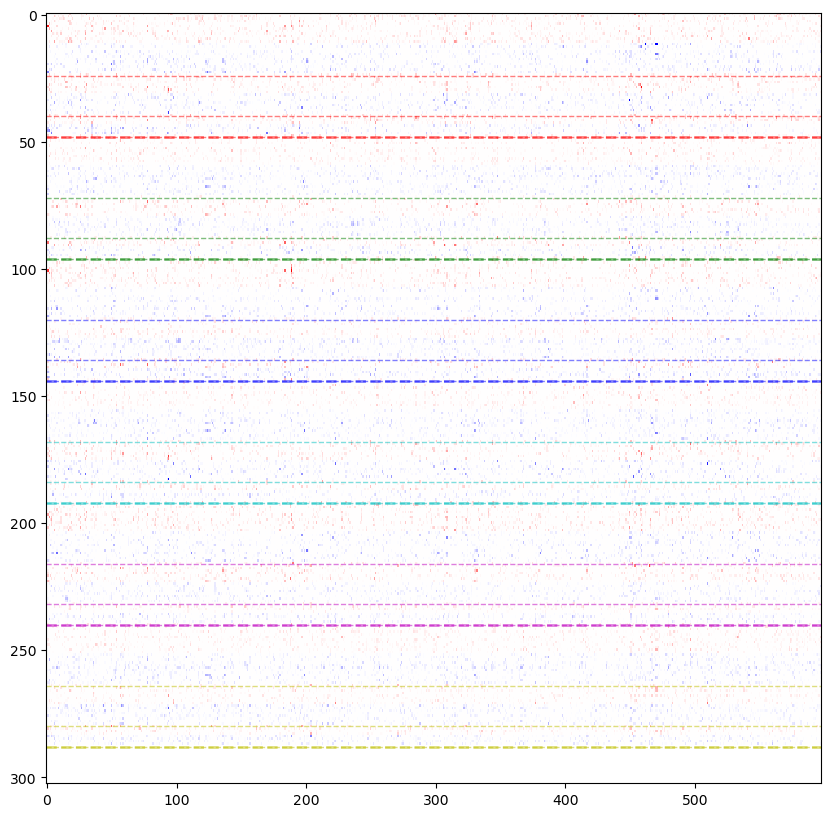

In [6]:
layer_num_inhs, layer_heights, layer_bounds, readout_weights = mplt.get_readout_weights(model, group_orientations=True)
print(readout_weights.shape)

# 6 orientations per layer, and we have 24 layers
# we need to grab the first, then the 7th, then the 13th, etc.
# and rearrange the weights so that they are interleaved, like this

# create list of Layer objects from the readout weights
layers = []
orientation = 0
for bound in range(1, len(layer_bounds)):
    if bound == 0:
        indexes = np.arange(layer_bounds[bound])
    else:
        indexes = np.arange(layer_bounds[bound-1], layer_bounds[bound])
    weights = readout_weights[indexes, :]
    print(weights.shape)
    layers.append(Layer(indexes, weights, orientation))
    orientation += 1
    if orientation == 6:
        orientation = 0

# rearrange the layers by orientation
print(len(layers), len(layer_bounds))
orientation_to_layer = {}
for layer in layers:
    orientation = layer.orientation
    if orientation not in orientation_to_layer:
        orientation_to_layer[orientation] = []
    orientation_to_layer[orientation].append(layer)
    
layers = []
for orientation in range(6):
    layers.extend(orientation_to_layer[orientation])

# convert the list of layers back to a numpy array
readout_weights = np.concatenate([layer.weights for layer in layers], axis=0)
print(readout_weights.shape)

fig = plt.figure(figsize=(10,10))
vmax = readout_weights.max()
plt.imshow(readout_weights, cmap='bwr', aspect='auto', vmin=-vmax, vmax=vmax, interpolation='none')

# plot the layer boundaries
bound = 0
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for orientation in orientation_to_layer.keys():
    for layer in orientation_to_layer[orientation]:
        bound += layer.indexes[-1] - layer.indexes[0]+1
        plt.axhline(bound, color=colors[orientation], linewidth=1, linestyle='--', alpha=0.5)
    else:
        plt.axhline(bound, color=colors[orientation], linewidth=2, linestyle='--', alpha=0.5)

# cells list

In [7]:
# populate the cells list
cells = []
for i in range(readout_weights.shape[1]):
    cells.append(Cell(i, layers))
    
for cell in cells:
    print(cell.orientation_to_readout[0].shape)
    print(cell.orientation_to_readout[1].shape)

(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,

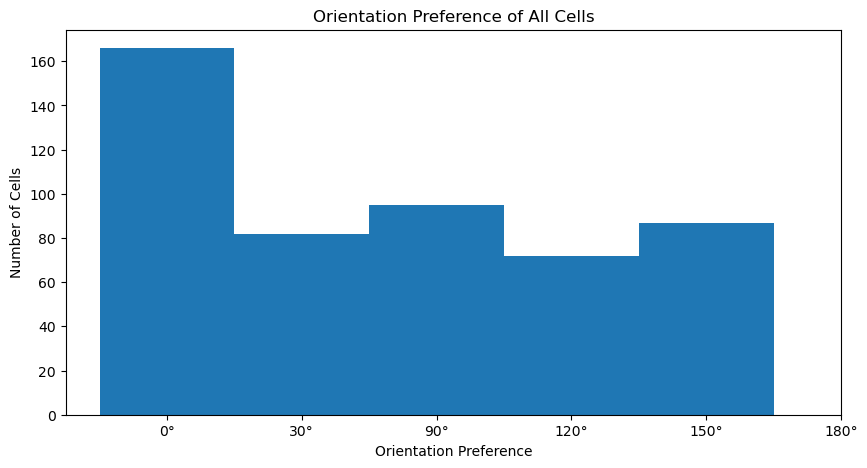

In [10]:
# cluster cells by their orientation preference

# make a histogram by the orientation preference of each cell
# based on the orientation with the maximum readout weights (absolute value) for that cell

# get the orientation preference of each cell
orientation_preferences = []
for cell in cells:
    orientation_to_readout = cell.orientation_to_readout
    max_orientation = 0
    max_readout = 0
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(np.abs(readout))
        if sum_readout > max_readout:
            max_readout = sum_readout
            max_orientation = orientation
    orientation_preferences.append(max_orientation)
    
# make a histogram of the orientation preferences
fig = plt.figure(figsize=(10,5))
plt.hist(orientation_preferences, bins=np.arange(6)-0.5)
plt.xlabel('Orientation Preference')
plt.ylabel('Number of Cells')
plt.title('Orientation Preference of All Cells')
# label the x-axis by angle (0, 30, 90, 120, 150, 180)
plt.xticks([0, 1, 2, 3, 4, 5], ['0°', '30°', '90°', '120°', '150°', '180°'])
plt.show()

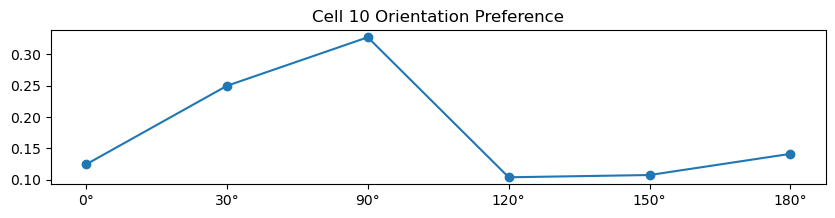

90.0


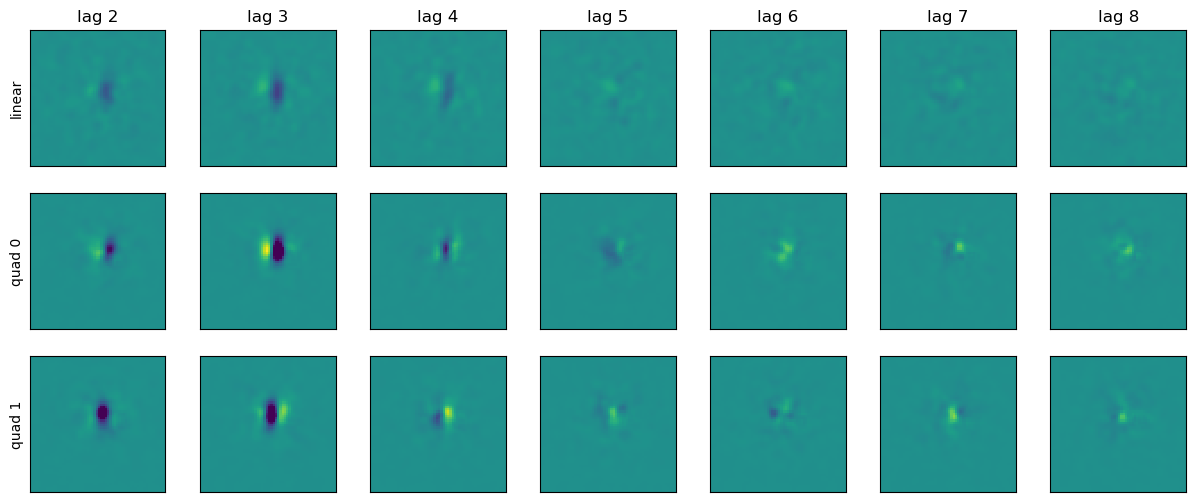

In [14]:
# for a cell plot the total abs values for each orientation
from ColorDataUtils import RFutils

def ori_pref(cell):
    orientation_to_readout = cells[cell].orientation_to_readout
    sum_readouts = []
    max_sum_readout = 0
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(np.abs(readout))
        sum_readouts.append(sum_readout)
        if sum_readout > max_sum_readout:
            max_sum_readout = sum_readout
            max_orientation = orientation
    return sum_readouts, max_orientation

cell = 10

fig = plt.figure(figsize=(10,2))
plt.plot(np.arange(6), ori_pref(cell)[0], 'o-')
# label the x-axis by angle (0, 30, 90, 120, 150, 180)
plt.xticks([0, 1, 2, 3, 4, 5], ['0°', '30°', '90°', '120°', '150°', '180°'])
plt.title(f'Cell {cell} Orientation Preference')
plt.show()

fname = f'/Data/ColorV1/J220715/LUMmodels/UT{cell:03}gqmwET.pkl'
with open(fname, 'rb') as f:
    gqm = pickle.load(f)

max_dir_score, max_dir_score_angle, max_motion_im = RFutils.GQM_direction(gqm, lin_net=0, quad_net=2)
print(max_dir_score_angle+90)

mplt.plot_gqm(gqm)

# PLOTS

In [ ]:
mplt.plot_proj_filters(model)

# compare GQM ori and readout

In [61]:
LLs[1], len(LLs)

(0.1171335, 598)

In [62]:
expt_names, expts.experiment_boundaries

(['J220715', 'J220722', 'J220707', 'J220801'],
 [(0, 174), (174, 299), (299, 450), (450, 598)])

# aggregate comparisons

In [0]:
cell_to_gqm = {}
for expt_idx, (start,end) in enumerate(expts.experiment_boundaries):
    for ci, cell in enumerate(range(start, end)):
        if expt_idx == 0:
            fname = f'/Data/ColorV1/J220715/LUMmodels/UT{ci:03}gqmwET.pkl'
        elif expt_idx == 1:
            fname = f'/Data/ColorV1/J220722/LUMmodels/UT{ci:03}gqmwET.pkl'
        elif expt_idx == 2:
            fname = f'/Data/ColorV1/J220707/models/UT{ci:03}gqmwET.pkl'
        # elif expt_idx == 3:
        #     fname = f'/Data/ColorV1/J220801/UT{ci:03}gqmwET.pkl'
        with open(fname, 'rb') as f:
            gqm = pickle.load(f)
        cell_to_gqm[cell] = gqm

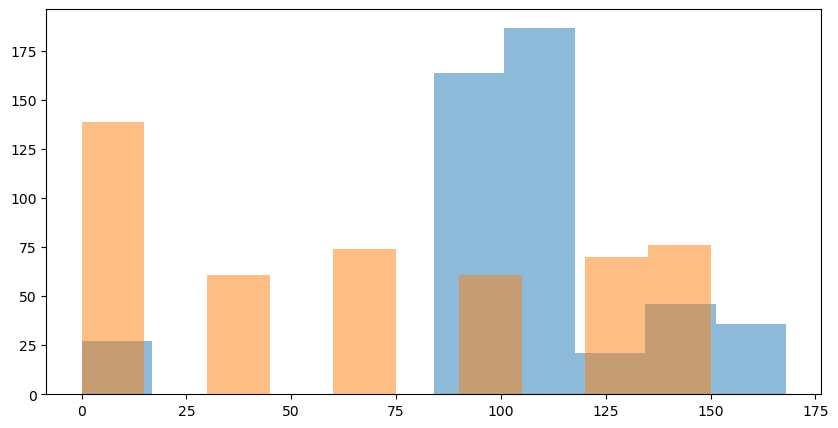

In [75]:
readout_prefs = []
gqm_prefs = []
for cell in range(len(LLs)):
    if LLs[cell] < 0.001:
        continue
    if cell not in cell_to_gqm:
        continue
        
    prefs, max_readout_pref = ori_pref(cell)
    max_readout_pref = max_readout_pref*30

    gqm = cell_to_gqm[cell]
    max_dir_score, max_dir_score_angle, max_motion_im = RFutils.GQM_direction(gqm, lin_net=0, quad_net=2)
    max_gqm_pref = max_dir_score_angle+90
    
    # if GQM is greater than 180, we need to make it less than 180
    if max_gqm_pref >= 180:
        max_gqm_pref -= 180
        
    readout_prefs.append(max_readout_pref)
    gqm_prefs.append(int(max_gqm_pref))

fig = plt.figure(figsize=(10,5))
plt.hist(gqm_prefs, alpha=0.5)
plt.hist(readout_prefs, alpha=0.5)
plt.show()

In [76]:
len(readout_prefs), len(gqm_prefs)
readout_prefs[1], gqm_prefs[1]

(0, 0)

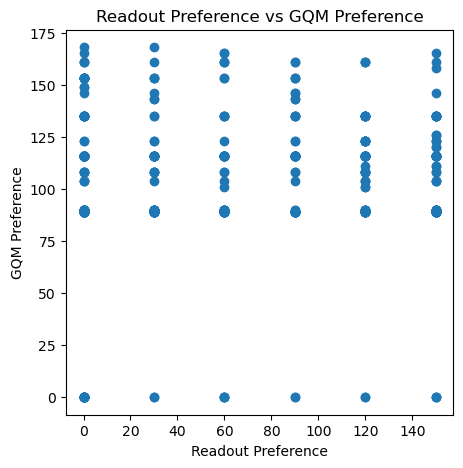

In [78]:
# plot the readout preferences vs the GQM preferences
fig = plt.figure(figsize=(5,5))
plt.plot(readout_prefs, gqm_prefs, 'o')
plt.xlabel('Readout Preference')
plt.ylabel('GQM Preference')
plt.title('Readout Preference vs GQM Preference')
plt.show()

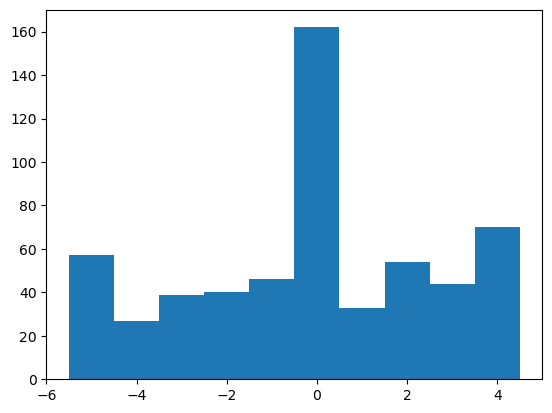

array([[-0.06065688,  0.05460445, -0.01857468, -0.08765058, -0.04518319,
         0.0035345 ],
       [-0.05332948,  0.04569429, -0.00853284, -0.03559335,  0.27340534,
        -0.01316201],
       [ 0.19224653,  0.06404596,  0.02811767,  0.17402545,  0.14203052,
        -0.12113614],
       ...,
       [ 0.04779223, -0.06445789, -0.0059453 , -0.03283196, -0.0260174 ,
        -0.00534702],
       [ 0.10499755,  0.06834669, -0.00396559,  0.0488175 , -0.02140892,
         0.00350023],
       [ 0.01634965,  0.02054028, -0.03247925,  0.02943728, -0.00506436,
         0.0036126 ]], dtype=float32)

In [164]:
# cluster cells by orientation preferences (using UMAP)
import umap
import hdbscan

# get the orientation preferences for each cell
cell_orientation_preferences = []
orientation_preferences = []
for cell in cells:
    orientation_to_readout = cell.orientation_to_readout
    max_orientation = 0
    min_orientation = 0
    max_readout = 0
    min_readout = 0
    cell_orientation_preference = []
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(readout)
        cell_orientation_preference.append(sum_readout)
        if sum_readout > max_readout:
            max_readout = sum_readout
            max_orientation = orientation
        if sum_readout < min_readout:
            min_readout = sum_readout
            min_orientation = -orientation
        # use the larger of the min and max orientation
        if np.abs(min_readout) > max_readout:
            max_orientation = min_orientation
            max_readout = min_readout
    orientation_preferences.append(max_orientation)
    cell_orientation_preferences.append(cell_orientation_preference)
    
# convert the list of cell orientation preferences to a numpy array
cell_orientation_preferences = np.array(cell_orientation_preferences)

plt.hist(orientation_preferences, bins=np.arange(-5,6)-0.5)
plt.show()

cell_orientation_preferences

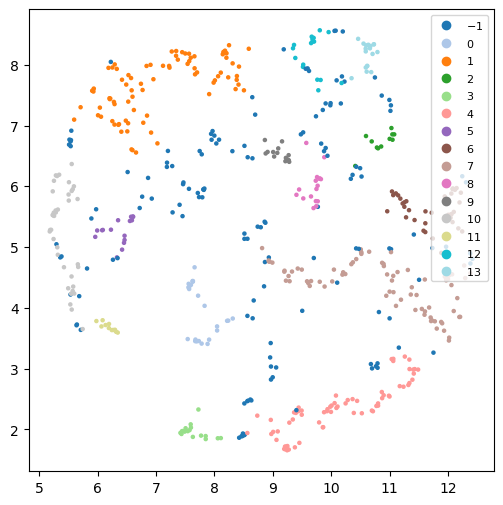

In [183]:
# get the UMAP embedding
embedding = umap.UMAP(n_neighbors=10, min_dist=0, metric='cosine').fit_transform(cell_orientation_preferences)

# cluster the embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(embedding)

# plot the embedding
fig = plt.figure(figsize=(6,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=clusterer.labels_, cmap='tab20', s=5)
# plot legend
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], loc='upper right', fontsize=8)
plt.show()

# plot some clustered cells

In [184]:
def best_gqm_filter(gqm, lin_net=0, quad_net=2):
    linear = gqm.networks[lin_net].layers[0].get_weights()[:,:, :, 0]
    quad0 = gqm.networks[quad_net].layers[0].get_weights()[:,:, :, 0]
    quad1 = gqm.networks[quad_net].layers[0].get_weights()[:,:, :, 1]
    best_gqm_filter = None
    best_gqm_var = None
    for li, layer in enumerate([linear, quad0, quad1]):
        # get the lag with the clearest receptive field (highest variance)
        best_lag = RFutils.get_best_lag(layer)
        # get the GQM filter at the best lag
        gqm_filter = layer[:, :, best_lag]
        # get the variance of the GQM filter
        gqm_var = np.var(gqm_filter)
        if best_gqm_var is None or gqm_var > best_gqm_var:
            best_gqm_var = gqm_var
            best_gqm_filter = gqm_filter
    return best_gqm_filter

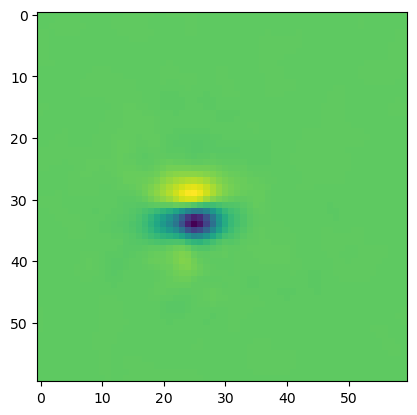

In [185]:
plt.imshow(best_gqm_filter(cell_to_gqm[10]))

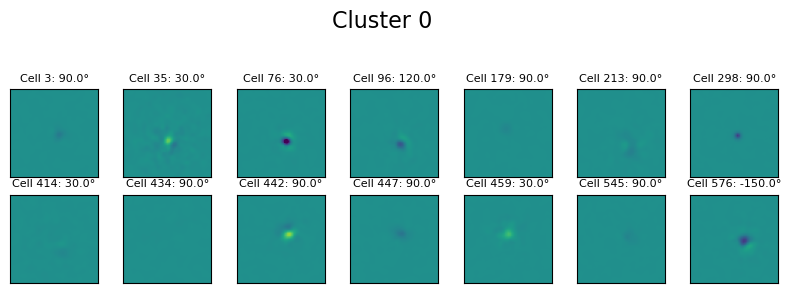

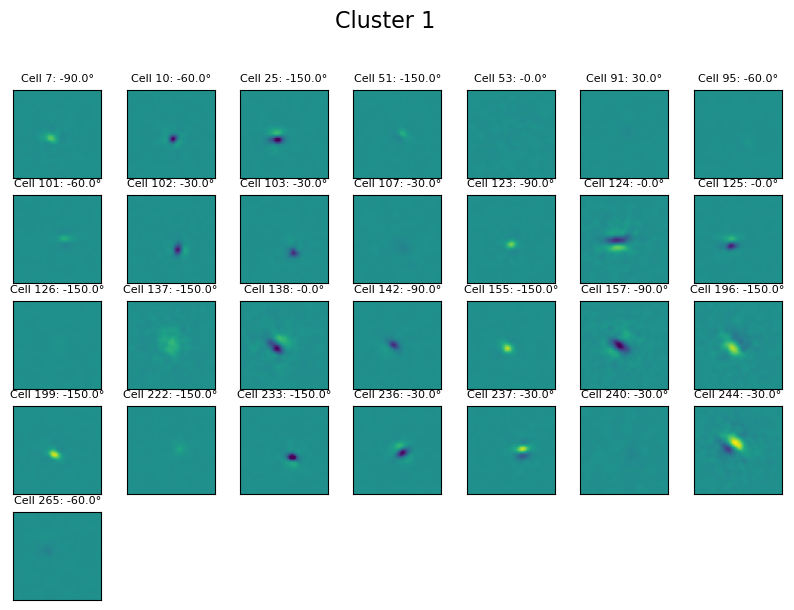

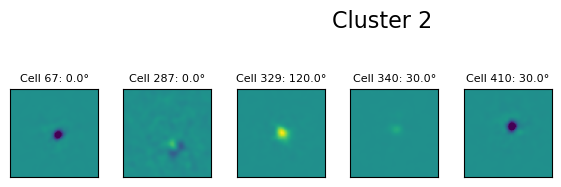

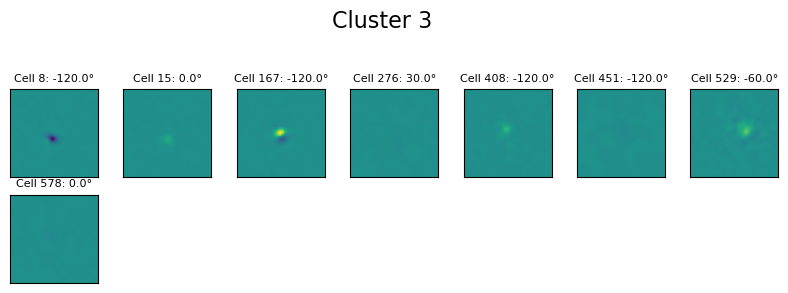

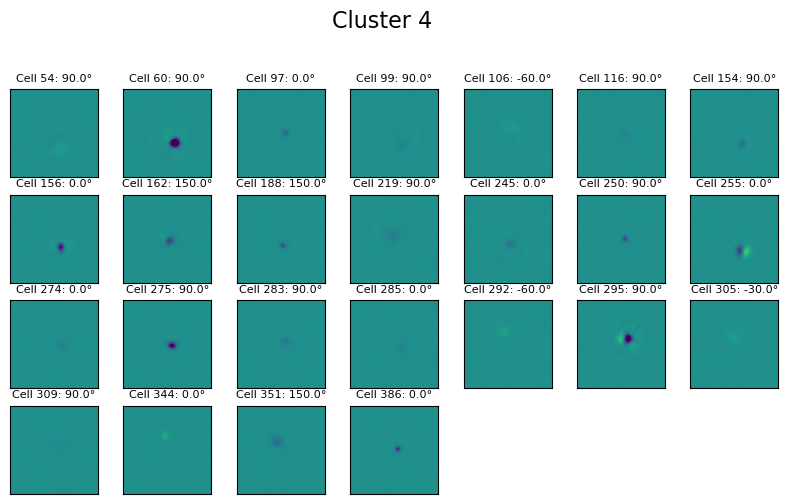

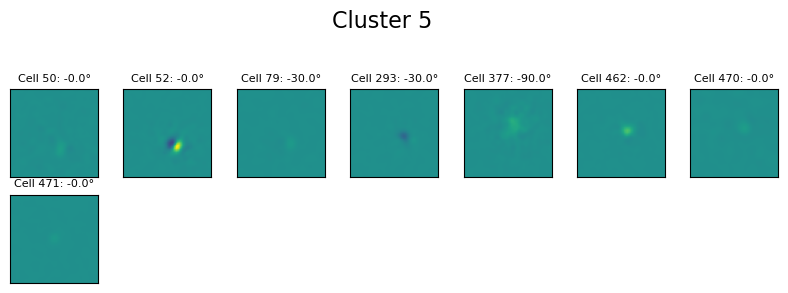

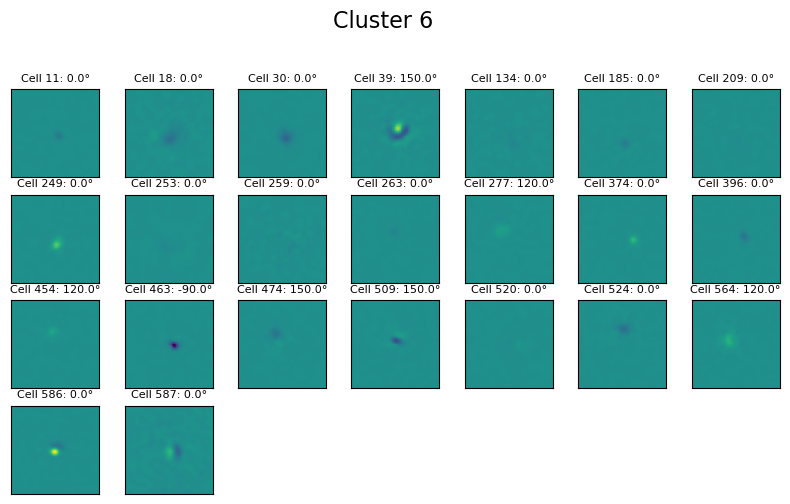

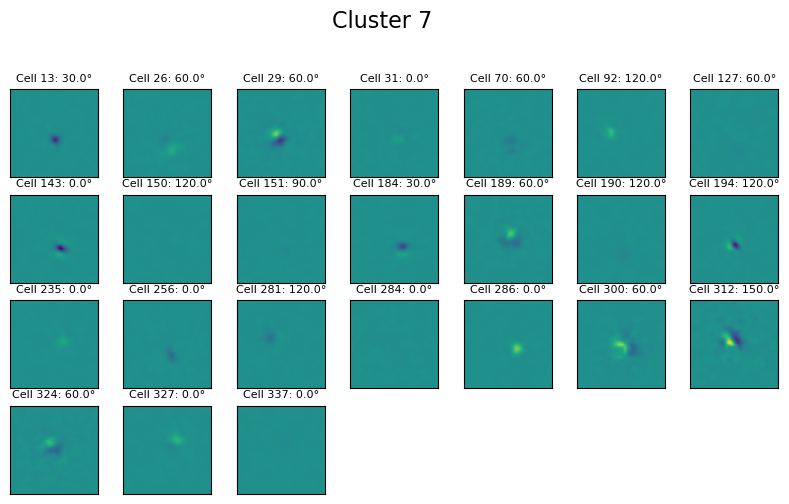

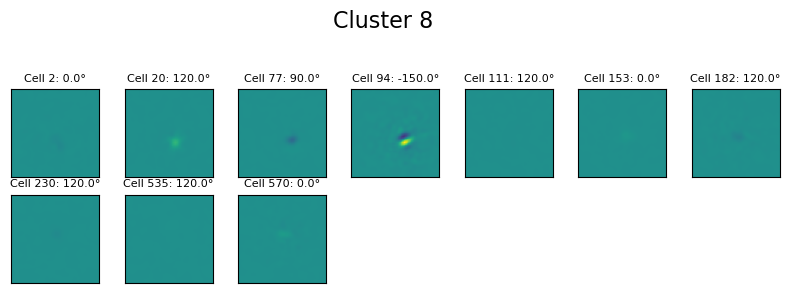

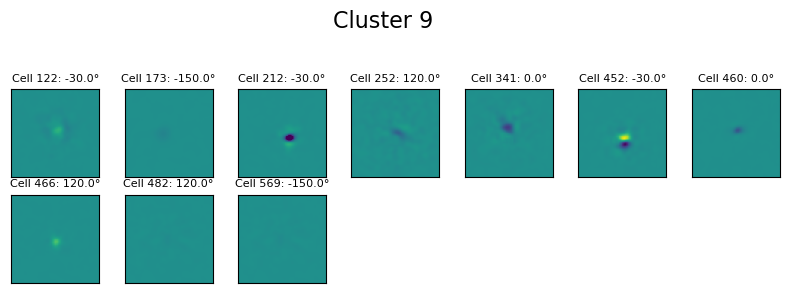

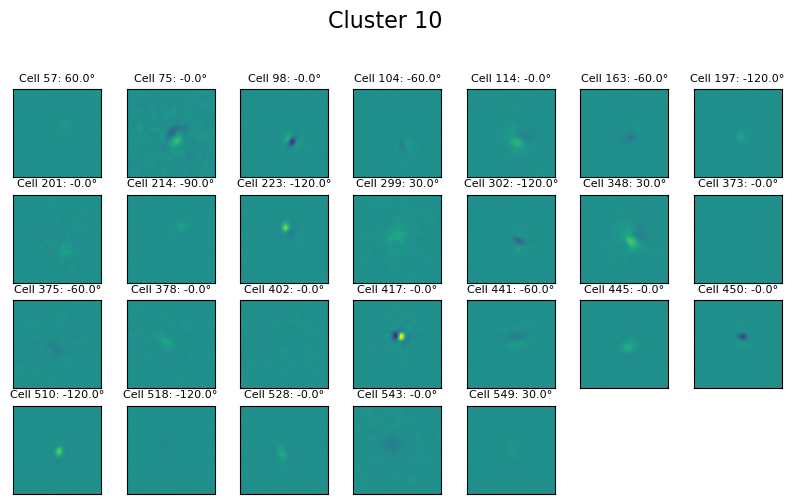

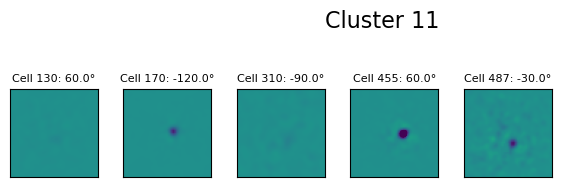

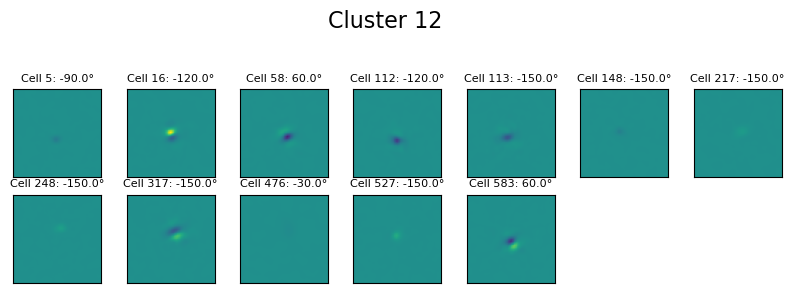

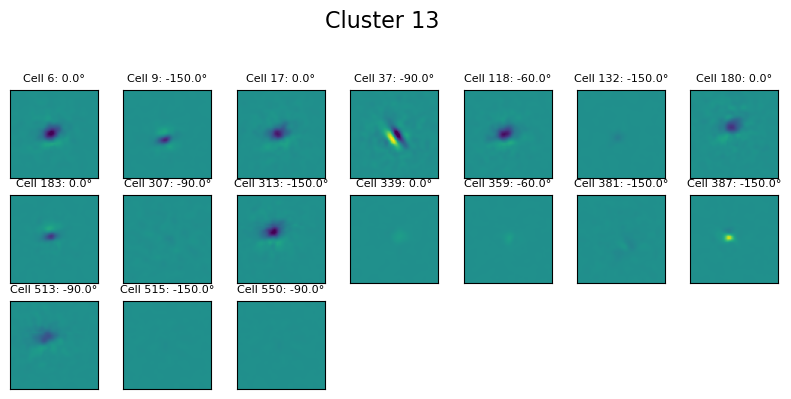

In [190]:
# plot best lag for GQMs in a cluster
for cluster in range(14):
    cluster_cells = np.where(clusterer.labels_ == cluster)[0]
    
    gqms = [cell_to_gqm[cell] for cell in cluster_cells[:42]]
    vmax = np.max([np.max(best_gqm_filter(gqm)) for gqm in gqms])
    
    fig = plt.figure(figsize=(10,8))
    i = 0
    for cell in cluster_cells[:42]:
        if LLs[cell] < 0.01:
            continue
        max_ori_pref = np.abs(cell_orientation_preferences[cell]).argmax()
        # convert the orientation preference to an angle
        max_ori_pref_angle = max_ori_pref*30 * np.sign(cell_orientation_preferences[cell][max_ori_pref])
        gqm = gqms[i]
        plt.subplot(6, 7, i+1)
        plt.imshow(best_gqm_filter(gqm), vmin=-vmax, vmax=vmax)
        plt.title(f'Cell {cell}: {max_ori_pref_angle}°', fontsize=8)
        # turn off axis labels
        plt.xticks([])
        plt.yticks([])
        i += 1
    plt.suptitle(f'Cluster {cluster}', fontsize=16)
    plt.show()

# get orientation preference

In [142]:
from skimage import measure
from skimage.feature import peak_local_max
from skimage import filters

def get_angle_between_points(x, y):
    # get the vector between the two peaks
    v = np.array([x[1]-x[0], y[1]-y[0]])
    # get the length of the vector
    v_len = np.sqrt(v[0]**2 + v[1]**2)
    # normalize the vector
    v = v / v_len
    # get the angle of the vector
    angle = np.arctan(v[1]/v[0])
    # convert to degrees
    angle = np.abs(angle * 180 / np.pi)
    return angle

def get_orientation(im):
    # get the FFT of the image at the current lag
    fftim2D = np.fft.fft2(im)
    fftim2D = np.fft.fftshift(fftim2D)
    fftim2D_abs = np.abs(fftim2D)

    # find the peaks in the image to find the direction of orientation
    smoothed_fftim = filters.gaussian(fftim2D_abs, sigma=6, truncate=0.1)
    peaks = peak_local_max(np.abs(smoothed_fftim), min_distance=2, threshold_rel=0.1)

    # if there are no peaks, then we can't measure the direction of motion
    if len(peaks) == 2:
        # get the x and y coordinates of the peaks
        x = peaks[:, 1]
        y = peaks[:, 0]
        angle = get_angle_between_points(x, y)
        return angle, peaks
    else:
        return None, None

(4, 1)
30.96375653207352


# load a GQM

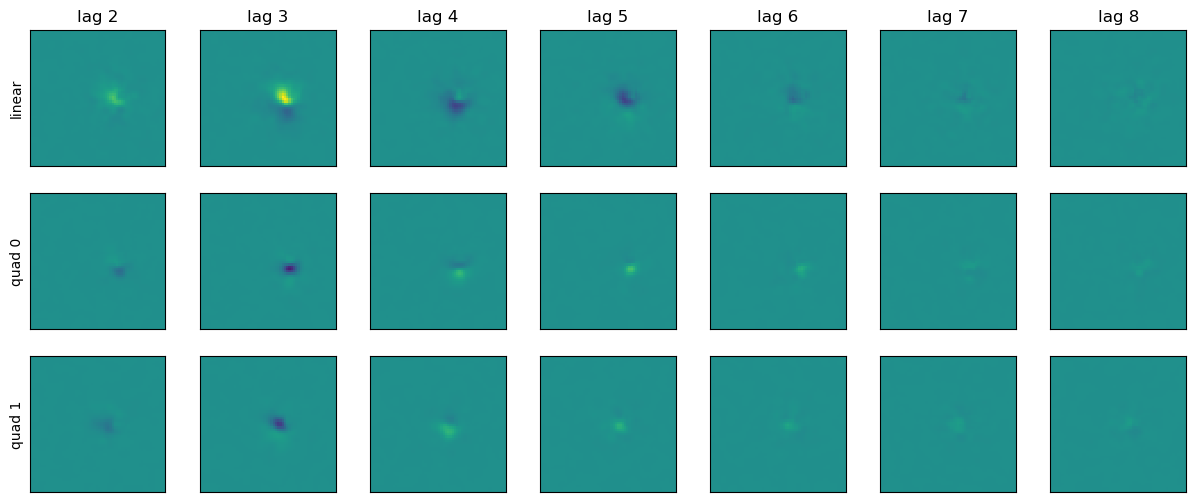

In [91]:
fname = '/Data/ColorV1/J220715/LUMmodels/UT001gqmwET.pkl'
with open(fname, 'rb') as f:
    gqm = pickle.load(f)

mplt.plot_gqm(gqm)

# plot readout 

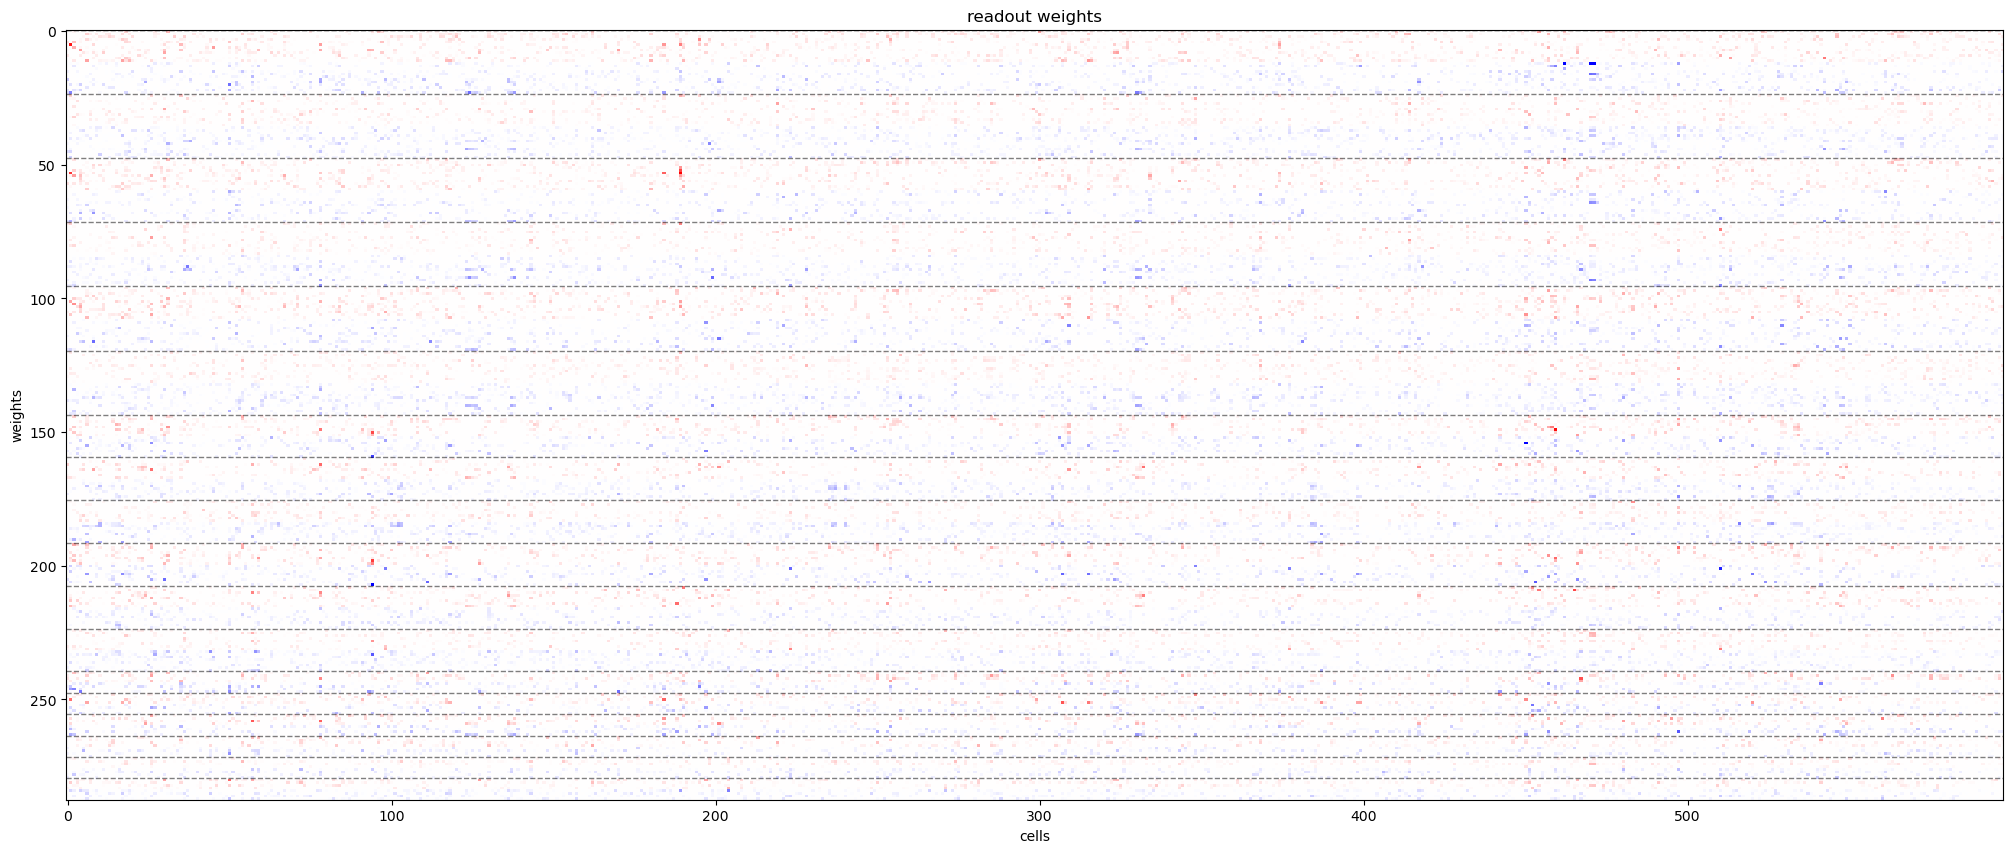

In [13]:
mplt.plot_readout_weights(model, group_orientations=True)

# OSI

In [140]:
import scipy
# import filters
from scipy.ndimage import filters

def orientation_tuning_curves_mean(frequencies, inds, norms, angles, orientations, max_norm, min_norm):
    flattened_freq=frequencies.flatten()
    mean_responses=[]
    epsilon=(orientations[1]-orientations[0])/2
    for k in range(len(orientations)):
        theta=orientations[k]
        integrands=[]
        for j in range(len(angles)):
            angle=np.abs(angles[j])
            if norms[j]>max_norm or norms[j]<min_norm:
                continue
            else:
                if theta-epsilon<angle<theta+epsilon or theta-epsilon<angle+2*np.pi<theta+epsilon:
                    integrands.append(flattened_freq[j])
                else:
                    continue
        mean_responses.append(np.mean(integrands))
    OSI_mean=(np.max(mean_responses)-np.min(mean_responses))/(np.max(mean_responses)+np.min(mean_responses))
    return mean_responses, OSI_mean

def grid_center_angles_and_norms(N):
    if N%2==0:
        grid_x_pos = np.repeat((np.linspace(-(N-1), N-1, N)), N)
        grid_y_pos = np.tile((np.linspace(-(N-1), N-1, N)), N)
    if N%2==1:
        grid_x_pos = np.tile(np.linspace(-np.floor(N/2), np.floor(N/2), N), N)
        grid_y_pos =np.tile(np.linspace(-np.floor(N/2), np.floor(N/2), N), N)
    center_angles=[]
    norms=[]
    for i in range(len(grid_y_pos)):
        norms.append(scipy.linalg.norm(np.array([grid_x_pos[i]/2, grid_y_pos[i]/2])))
        base_angle=np.arctan2(grid_y_pos[i], grid_x_pos[i])
        center_angles.append(base_angle)
    return center_angles, norms

def binned_norms(norms, bin_size):
    sorted_norm_inds=np.argsort(norms)
    counts, bins=np.histogram(norms, bin_size)
    inds=np.insert(np.cumsum(counts), 0, 0)
    return inds, bins

def norm_truncation(norms, threshold):
    sorted_norm_inds=np.argsort(norms)
    sorted_norms=np.asarray(norms)[sorted_norm_inds]
    cutoff=np.max(np.nonzero(sorted_norms<threshold*np.ones(len(sorted_norms))))
    valid_norms=sorted_norms[0:cutoff]
    return valid_norms

def combined_GQM_fourier_transform(gqm, scale, best_lag):
    assert len(scale)==1 or len(scale)==3, "Weights must have length 1 or 3"
    w0=gqm.get_weights(ffnet_target=0).reshape(60, 60, -1)
    w1=gqm.get_weights(ffnet_target=2)[:, :, :, 0].reshape(60, 60, -1)
    w2=gqm.get_weights(ffnet_target=2)[:, :, :, 1].reshape(60, 60, -1)
    weightlist=[w0, w1, w2]
    fft_list=[]
    for j in range(3):
        im=weightlist[j][:, :, -best_lag].T #Why is this getting transposed? 
        fftim2D = np.fft.fft2(im)
        fftim2D= np.fft.fftshift(fftim2D)
        fftim2D_abs = np.abs(fftim2D)
        smoothed_fftim = filters.gaussian(fftim2D_abs, sigma=10, truncate=1/5)
        fft_list.append(smoothed_fftim)
    if len(scale)==1:
        summed_fft=(1-scale)*fft_list[0]+0.5*scale*(fft_list[1]+fft_list[2])
    else:
        summed_fft=scale[0]*fft_list[0]+scale[1]*fft_list[1]+scale[2]*fft_list[2]
    return summed_fft #I guess we'll keep these guys around in here too.

def get_frequency_tuning_curve(inds, frequencies, norms):
    flattened_freq=frequencies.flatten()
    sorted_norm_inds=np.argsort(norms)
    frequency_tuning_curve=[]
    for j in range(len(inds)-1):
        indices=sorted_norm_inds[inds[j]:inds[j+1]]
        frequency_tuning_curve.append(np.mean(flattened_freq[indices])) #Oh. Okay, that's why it blows up. 
    return frequency_tuning_curve

summed_ffts = []
summed_fft = combined_GQM_fourier_transform(
    core_gqm, filter_weights, best_lag)
summed_ffts.append(summed_fft)

frequency_tuning_curve = get_frequency_tuning_curve(
    finer_inds, summed_fft, valid_norms)

orientation_tuning_curve, OSI = orientation_tuning_curves_mean(
    summed_fft, inds, norms, center_angles, 
    orientations, finer_bins[-2], finer_bins[1])



NameError: name 'core_gqm' is not defined